In [1]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install nltk pandas scikit-learn


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


[INFO] Dataset loaded
[INFO] Date Preprocessing and cleaning Done
[INFO] Graphs Created
[INFO] Graph Data Saved -> graphs.pt


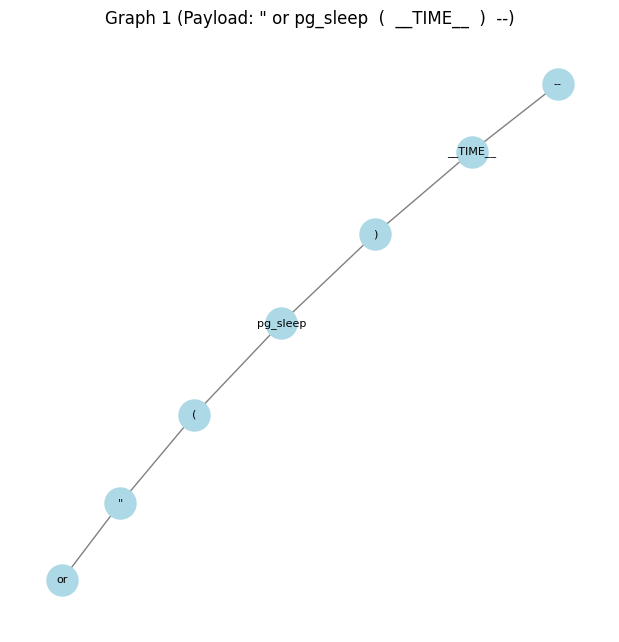

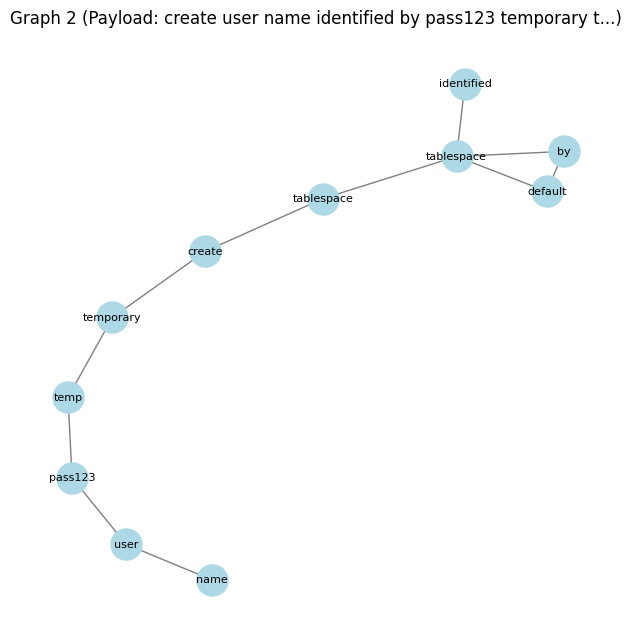

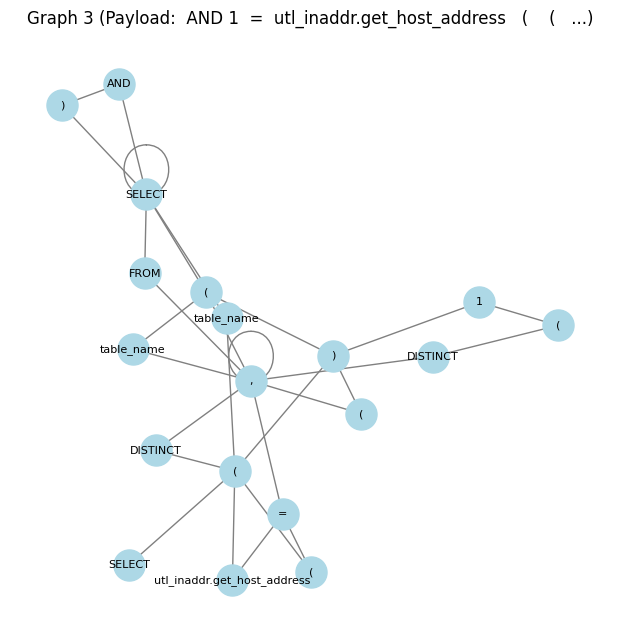

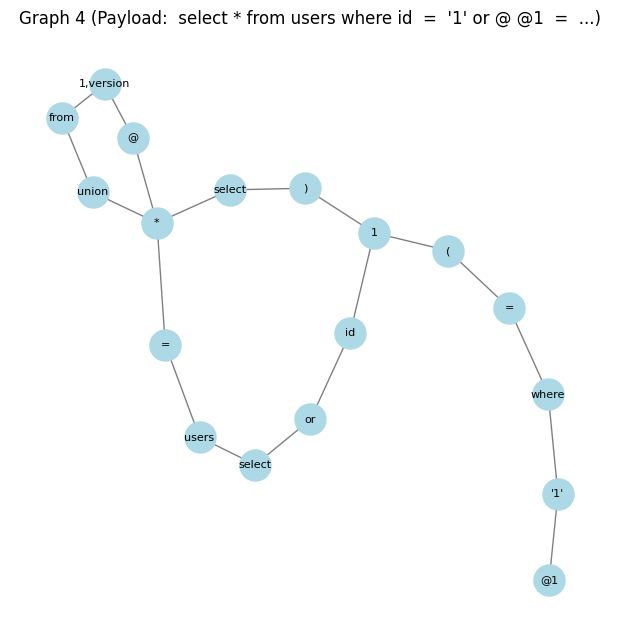

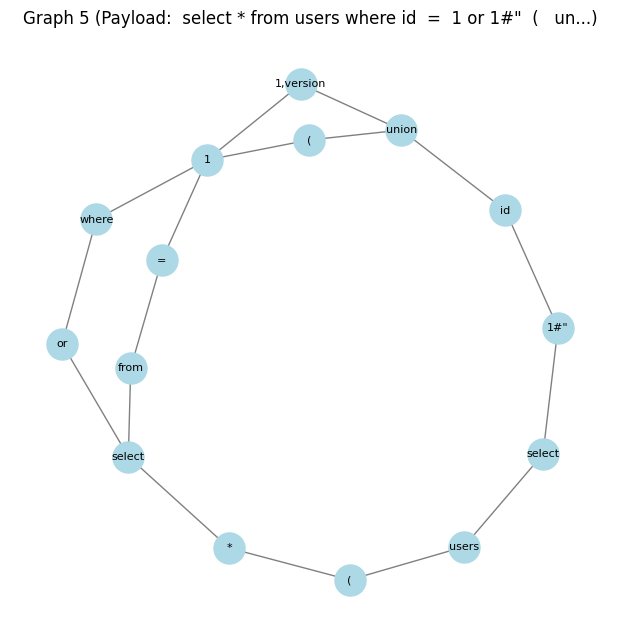

In [4]:
import torch
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#  Load dataset
df = pd.read_csv("/content/Sql-Xss-Injection-Dataset.csv")
print("[INFO] Dataset loaded")

#  Remove NaN & invalid labels
df = df[df["Label"].astype(str).str.isnumeric()]  # Keep only numeric labels (0 or 1)
df["Label"] = df["Label"].astype(float)  # Convert to float

#  Ensure Payload column is properly formatted as strings
df["Payload"] = df["Payload"].astype(str).fillna("")
print("[INFO] Date Preprocessing and cleaning Done")

#  Graph Conversion Function
def text_to_graph(text):
    if not isinstance(text, str) or text.strip() == "":
        return [], {}, torch.empty((2, 0), dtype=torch.long)

    words = text.split()
    if len(words) == 0:
        return [], {}, torch.empty((2, 0), dtype=torch.long)

    # Assign a unique index to each unique word
    word_to_index = {word: idx for idx, word in enumerate(set(words))}

    # Create edges between adjacent words using their unique indices
    edges = [(word_to_index[words[i]], word_to_index[words[i + 1]]) for i in range(len(words) - 1)]
    edge_index = torch.tensor(edges, dtype=torch.long).t() if edges else torch.empty((2, 0), dtype=torch.long)

    return list(word_to_index.keys()), word_to_index, edge_index



graphs = []
payloads = []
word_mappings = []  # Store word-to-index mappings for labels

for _, row in df.iterrows():
    payload, label = row["Payload"], row["Label"]
    nodes, word_to_index, edge_index = text_to_graph(payload)

    if len(nodes) == 0:
        continue

    x = torch.rand(len(nodes), 16) * 0.01
    y = torch.tensor([label], dtype=torch.float)

    graphs.append(Data(x=x, edge_index=edge_index, y=y))
    payloads.append(payload)
    word_mappings.append(word_to_index)  #  Store word-to-index mapping


print("[INFO] Graphs Created")
torch.save(graphs, "/content/graphs.pt")
print("[INFO] Graph Data Saved -> graphs.pt")

# Visualize First 5 Graphs with Node Labels
def plot_graph(graph, payload, idx):
    G = nx.Graph()
    num_nodes = graph.x.shape[0]
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(graph.edge_index.t().tolist())

    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G)  # Layout for better spacing

    # Ensure node_labels only includes nodes that exist in G
    words = payload.split()
    node_labels = {i: words[i] for i in range(min(len(words), num_nodes))}  # Match words to valid nodes

    # Ensure no missing keys in pos
    node_labels = {k: v for k, v in node_labels.items() if k in G.nodes}

    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color="lightblue", edge_color="gray", node_size=500, font_size=8)
    plt.title(f"Graph {idx+1} (Payload: {payload[:50]}...)" if len(payload) > 50 else f"Graph {idx+1} (Payload: {payload})")
    plt.show()


for i in range(min(5, len(graphs))):
    plot_graph(graphs[i], payloads[i], i)


In [5]:
#  Train-Test Split
train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

print(f"[INFO] Training samples: {len(train_graphs)}, Testing samples: {len(test_graphs)}")


[INFO] Training samples: 35589, Testing samples: 8898


In [6]:
# Save Data
torch.save(train_graphs, "/content/train_graphs.pt")
torch.save(test_graphs, "/content/test_graphs.pt")
print("[INFO] Train & Test Data Saved")

[INFO] Train & Test Data Saved


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.loader import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# Define Improved Model
class ImprovedGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)  # Added extra layer
        self.bn3 = BatchNorm(hidden_dim)
        self.classifier = torch.nn.Linear(hidden_dim, 1)  # Binary classification

        self._init_weights()

    def _init_weights(self):
        for module in [self.conv1, self.conv2, self.conv3]:
            if hasattr(module, 'weight') and module.weight is not None:
                torch.nn.init.kaiming_uniform_(module.weight, nonlinearity="leaky_relu")
            if hasattr(module, 'bias') and module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        torch.nn.init.zeros_(self.classifier.bias)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.leaky_relu(self.bn1(self.conv1(x, edge_index)), negative_slope=0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.leaky_relu(self.bn2(self.conv2(x, edge_index)), negative_slope=0.1)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.leaky_relu(self.bn3(self.conv3(x, edge_index)), negative_slope=0.1)

        # Global mean pooling
        x = global_mean_pool(x, batch)
        return self.classifier(x).squeeze(-1)

# Data preparation
train_graphs, val_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
train_loader = DataLoader(train_graphs, batch_size=64, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=128)

# Model setup
model = ImprovedGCN(input_dim=graphs[0].x.shape[1]).to(device)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Slightly higher weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Adjust for class imbalance
all_labels = torch.cat([graph.y for graph in graphs])
pos_weight = torch.tensor([all_labels.eq(0).sum() / all_labels.eq(1).sum()]).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    train_loss = 0
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    with tqdm(loader, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description("Training")
            batch = batch.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # Enable AMP for speed-up
                out = model(batch)
                loss = criterion(out, batch.y.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    return train_loss / len(loader)

# Validation function
def evaluate(model, loader, criterion):
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out, batch.y.float()).item()
            preds = (torch.sigmoid(out) > 0.5).float()
            val_correct += (preds == batch.y).sum().item()

    val_loss /= len(loader)
    val_acc = val_correct / len(loader.dataset)
    return val_loss, val_acc

# Training loop
best_val_acc = 0
for epoch in range(1, 50):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    scheduler.step(val_loss)  # Adjust learning rate based on validation loss

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "best_val_acc": best_val_acc
        }, "improved_model.pth")

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("[INFO] Training completed")


[INFO] Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-7-fc7927d0dd56>:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
Training:   0%|          | 0/557 [00:00<?, ?batch/s]<ipython-input-7-fc7927d0dd56>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable AMP for speed-up
Training: 100%|██████████| 557/557 [00:08<00:00, 66.06batch/s, loss=0.956]


Epoch 01 | Train Loss: 0.7827 | Val Loss: 0.8868 | Val Acc: 0.4472


Training: 100%|██████████| 557/557 [00:07<00:00, 76.90batch/s, loss=0.509]


Epoch 02 | Train Loss: 0.7265 | Val Loss: 0.7254 | Val Acc: 0.6165


Training: 100%|██████████| 557/557 [00:06<00:00, 83.50batch/s, loss=0.539]


Epoch 03 | Train Loss: 0.7073 | Val Loss: 0.9027 | Val Acc: 0.4912


Training: 100%|██████████| 557/557 [00:07<00:00, 76.42batch/s, loss=0.854]


Epoch 04 | Train Loss: 0.6939 | Val Loss: 0.6752 | Val Acc: 0.6897


Training: 100%|██████████| 557/557 [00:07<00:00, 75.49batch/s, loss=1.03]


Epoch 05 | Train Loss: 0.6861 | Val Loss: 0.9192 | Val Acc: 0.4549


Training: 100%|██████████| 557/557 [00:06<00:00, 81.51batch/s, loss=0.88]


Epoch 06 | Train Loss: 0.6809 | Val Loss: 0.6822 | Val Acc: 0.6676


Training: 100%|██████████| 557/557 [00:07<00:00, 76.33batch/s, loss=0.964]


Epoch 07 | Train Loss: 0.6768 | Val Loss: 0.6740 | Val Acc: 0.6996


Training: 100%|██████████| 557/557 [00:06<00:00, 82.06batch/s, loss=0.582]


Epoch 08 | Train Loss: 0.6746 | Val Loss: 0.6597 | Val Acc: 0.6997


Training: 100%|██████████| 557/557 [00:07<00:00, 78.15batch/s, loss=0.74]


Epoch 09 | Train Loss: 0.6702 | Val Loss: 0.6658 | Val Acc: 0.7006


Training: 100%|██████████| 557/557 [00:07<00:00, 76.87batch/s, loss=0.596]


Epoch 10 | Train Loss: 0.6676 | Val Loss: 0.6553 | Val Acc: 0.7036


Training: 100%|██████████| 557/557 [00:06<00:00, 82.57batch/s, loss=0.478]


Epoch 11 | Train Loss: 0.6633 | Val Loss: 1.0682 | Val Acc: 0.4994


Training: 100%|██████████| 557/557 [00:07<00:00, 75.21batch/s, loss=0.626]


Epoch 12 | Train Loss: 0.6589 | Val Loss: 0.6805 | Val Acc: 0.7005


Training: 100%|██████████| 557/557 [00:06<00:00, 79.87batch/s, loss=0.443]


Epoch 13 | Train Loss: 0.6570 | Val Loss: 1.2230 | Val Acc: 0.4803


Training: 100%|██████████| 557/557 [00:07<00:00, 74.84batch/s, loss=1.39]


Epoch 14 | Train Loss: 0.6570 | Val Loss: 0.8731 | Val Acc: 0.5192


Training: 100%|██████████| 557/557 [00:07<00:00, 75.99batch/s, loss=1.12]


Epoch 15 | Train Loss: 0.6545 | Val Loss: 0.6414 | Val Acc: 0.7250


Training: 100%|██████████| 557/557 [00:06<00:00, 82.58batch/s, loss=0.44]


Epoch 16 | Train Loss: 0.6466 | Val Loss: 0.6416 | Val Acc: 0.6975


Training: 100%|██████████| 557/557 [00:07<00:00, 76.01batch/s, loss=0.799]


Epoch 17 | Train Loss: 0.6457 | Val Loss: 0.6990 | Val Acc: 0.5959


Training: 100%|██████████| 557/557 [00:07<00:00, 75.75batch/s, loss=1.09]


Epoch 18 | Train Loss: 0.6422 | Val Loss: 1.2470 | Val Acc: 0.4822


Training: 100%|██████████| 557/557 [00:06<00:00, 82.61batch/s, loss=0.579]


Epoch 19 | Train Loss: 0.6405 | Val Loss: 0.6442 | Val Acc: 0.7192


Training: 100%|██████████| 557/557 [00:07<00:00, 76.25batch/s, loss=1.05]


Epoch 20 | Train Loss: 0.6359 | Val Loss: 0.6268 | Val Acc: 0.7312


Training: 100%|██████████| 557/557 [00:06<00:00, 81.71batch/s, loss=0.93]


Epoch 21 | Train Loss: 0.6370 | Val Loss: 0.7030 | Val Acc: 0.6044


Training: 100%|██████████| 557/557 [00:07<00:00, 76.74batch/s, loss=0.502]


Epoch 22 | Train Loss: 0.6259 | Val Loss: 0.7038 | Val Acc: 0.6870


Training: 100%|██████████| 557/557 [00:07<00:00, 75.80batch/s, loss=0.737]


Epoch 23 | Train Loss: 0.6251 | Val Loss: 0.6664 | Val Acc: 0.7085


Training: 100%|██████████| 557/557 [00:06<00:00, 82.07batch/s, loss=0.697]


Epoch 24 | Train Loss: 0.6223 | Val Loss: 0.8163 | Val Acc: 0.5169


Training: 100%|██████████| 557/557 [00:07<00:00, 76.07batch/s, loss=0.977]


Epoch 25 | Train Loss: 0.6199 | Val Loss: 0.5885 | Val Acc: 0.7490


Training: 100%|██████████| 557/557 [00:07<00:00, 79.34batch/s, loss=0.291]


Epoch 26 | Train Loss: 0.6133 | Val Loss: 0.6932 | Val Acc: 0.6977


Training: 100%|██████████| 557/557 [00:07<00:00, 78.84batch/s, loss=0.315]


Epoch 27 | Train Loss: 0.6087 | Val Loss: 0.5992 | Val Acc: 0.7396


Training: 100%|██████████| 557/557 [00:07<00:00, 75.49batch/s, loss=0.478]


Epoch 28 | Train Loss: 0.6093 | Val Loss: 1.7082 | Val Acc: 0.4711


Training: 100%|██████████| 557/557 [00:06<00:00, 81.96batch/s, loss=0.633]


Epoch 29 | Train Loss: 0.6048 | Val Loss: 0.6316 | Val Acc: 0.7248


Training: 100%|██████████| 557/557 [00:07<00:00, 75.51batch/s, loss=0.787]


Epoch 30 | Train Loss: 0.6005 | Val Loss: 0.5555 | Val Acc: 0.7614


Training: 100%|██████████| 557/557 [00:07<00:00, 78.57batch/s, loss=0.16]


Epoch 31 | Train Loss: 0.5994 | Val Loss: 0.5593 | Val Acc: 0.7651


Training: 100%|██████████| 557/557 [00:06<00:00, 80.89batch/s, loss=0.651]


Epoch 32 | Train Loss: 0.5994 | Val Loss: 0.5544 | Val Acc: 0.7629


Training: 100%|██████████| 557/557 [00:07<00:00, 75.87batch/s, loss=0.554]


Epoch 33 | Train Loss: 0.5942 | Val Loss: 0.6103 | Val Acc: 0.7180


Training: 100%|██████████| 557/557 [00:06<00:00, 81.64batch/s, loss=0.446]


Epoch 34 | Train Loss: 0.5911 | Val Loss: 0.6208 | Val Acc: 0.7030


Training: 100%|██████████| 557/557 [00:07<00:00, 75.54batch/s, loss=0.695]


Epoch 35 | Train Loss: 0.5911 | Val Loss: 0.5908 | Val Acc: 0.7406


Training: 100%|██████████| 557/557 [00:07<00:00, 75.90batch/s, loss=0.556]


Epoch 36 | Train Loss: 0.5900 | Val Loss: 0.5409 | Val Acc: 0.7678


Training: 100%|██████████| 557/557 [00:06<00:00, 80.41batch/s, loss=0.77]


Epoch 37 | Train Loss: 0.5921 | Val Loss: 0.5821 | Val Acc: 0.7589


Training: 100%|██████████| 557/557 [00:07<00:00, 74.44batch/s, loss=0.993]


Epoch 38 | Train Loss: 0.5865 | Val Loss: 0.5759 | Val Acc: 0.7594


Training: 100%|██████████| 557/557 [00:06<00:00, 79.88batch/s, loss=0.577]


Epoch 39 | Train Loss: 0.5882 | Val Loss: 0.5508 | Val Acc: 0.7669


Training: 100%|██████████| 557/557 [00:07<00:00, 76.97batch/s, loss=0.247]


Epoch 40 | Train Loss: 0.5836 | Val Loss: 0.5757 | Val Acc: 0.7566


Training: 100%|██████████| 557/557 [00:07<00:00, 74.46batch/s, loss=0.631]


Epoch 41 | Train Loss: 0.5902 | Val Loss: 0.5527 | Val Acc: 0.7649


Training: 100%|██████████| 557/557 [00:06<00:00, 81.39batch/s, loss=0.377]


Epoch 42 | Train Loss: 0.5860 | Val Loss: 0.5368 | Val Acc: 0.7661


Training: 100%|██████████| 557/557 [00:08<00:00, 69.16batch/s, loss=1.01]


Epoch 43 | Train Loss: 0.5824 | Val Loss: 0.5507 | Val Acc: 0.7623


Training: 100%|██████████| 557/557 [00:07<00:00, 75.63batch/s, loss=0.709]


Epoch 44 | Train Loss: 0.5829 | Val Loss: 0.5698 | Val Acc: 0.7602


Training: 100%|██████████| 557/557 [00:07<00:00, 78.43batch/s, loss=0.691]


Epoch 45 | Train Loss: 0.5812 | Val Loss: 0.5635 | Val Acc: 0.7614


Training: 100%|██████████| 557/557 [00:07<00:00, 74.38batch/s, loss=0.439]


Epoch 46 | Train Loss: 0.5818 | Val Loss: 0.5361 | Val Acc: 0.7690


Training: 100%|██████████| 557/557 [00:06<00:00, 81.16batch/s, loss=0.887]


Epoch 47 | Train Loss: 0.5812 | Val Loss: 0.5668 | Val Acc: 0.7631


Training: 100%|██████████| 557/557 [00:07<00:00, 75.59batch/s, loss=0.825]


Epoch 48 | Train Loss: 0.5813 | Val Loss: 0.5458 | Val Acc: 0.7685


Training: 100%|██████████| 557/557 [00:07<00:00, 74.70batch/s, loss=0.616]


Epoch 49 | Train Loss: 0.5778 | Val Loss: 0.5383 | Val Acc: 0.7696
[INFO] Training completed
